# Testing some optics parts 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import scipy
import pyfftw
from NN_utils import Lin_ONN

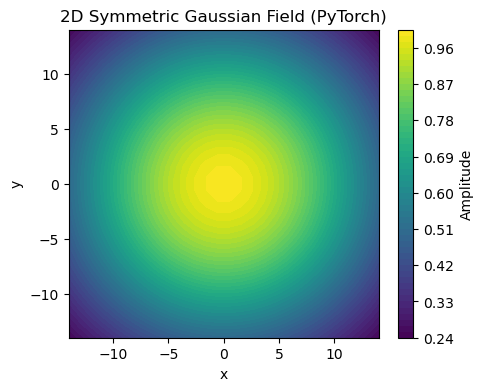

In [2]:
# Number of points in each dimension
N = 28

# Create 1D grids for x and y
x = torch.linspace(-round(N / 2), round(N / 2), N)
y = torch.linspace(-round(N / 2), round(N / 2), N)

# Create 2D meshgrid
X, Y = torch.meshgrid(x, y, indexing='ij')  # Use indexing='ij' for Cartesian indexing

# Gaussian parameters
x0, y0 = 0, 0  # Center of the Gaussian
fwhm = 28     # Full-width at half-maximum

# Convert FWHM to standard deviation (sigma)
sigma = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))

# Compute the 2D Gaussian field
E = torch.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))

# Convert the tensor to NumPy for plotting (PyTorch tensors aren't directly plottable)
E_np = E.numpy()

# Plot the Gaussian field
plt.figure(figsize=(5, 4))
plt.contourf(X.numpy(), Y.numpy(), E_np, levels=50, cmap='viridis')  # Convert X and Y to NumPy as well
plt.colorbar(label='Amplitude')
plt.title('2D Symmetric Gaussian Field (PyTorch)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [3]:
# Transform to convert images to Tensor and then threshold them
def to_boolean_tensor(image):
    # Convert the image to a tensor and apply a threshold of 0.5 (or any other threshold you prefer)
    return (image>0.1).float()

In [4]:
#MNIST dataset
MNIST_train = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(to_boolean_tensor)]), download=True)
MNIST_test = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(to_boolean_tensor)]), download=True)

#Dataloaders
train_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=10000, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_test, batch_size=10000, shuffle=False)


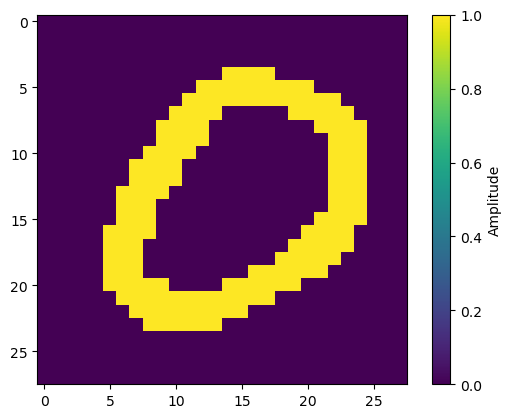

In [ ]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))
plt.imshow(np.squeeze(X_train_MNIST[0,0,:,:].detach().cpu().numpy()))
plt.colorbar(label='Amplitude')

In [6]:
#Broadcasting already takes care of matching the dimensions.
Gaussian_MNIST = X_train_MNIST*E 

Text(0.5, 1.0, 'MNIST modulating Gaussian Beam')

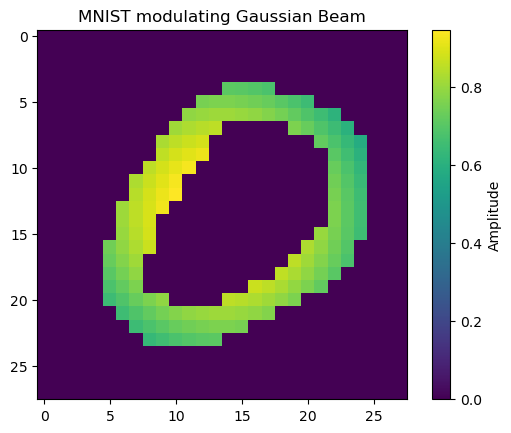

In [7]:
plt.imshow(np.squeeze(Gaussian_MNIST[0,0,:,:].detach().cpu().numpy()))
plt.colorbar(label='Amplitude')
plt.title('MNIST modulating Gaussian Beam')


In [13]:
# try to padd the images 

Gaussian_MNIST = torch.nn.functional.pad(Gaussian_MNIST, (10, 10, 10, 10))  # (left, right, top, bottom)


Text(0.5, 1.0, 'MNIST modulating Gaussian Beam')

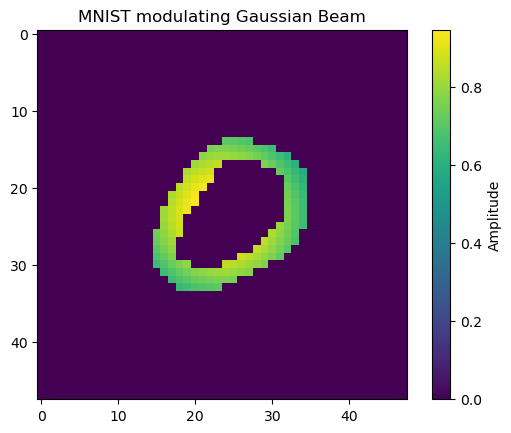

In [14]:
plt.imshow(np.squeeze(Gaussian_MNIST[0,0,:,:].detach().cpu().numpy()))
plt.colorbar(label='Amplitude')
plt.title('MNIST modulating Gaussian Beam')


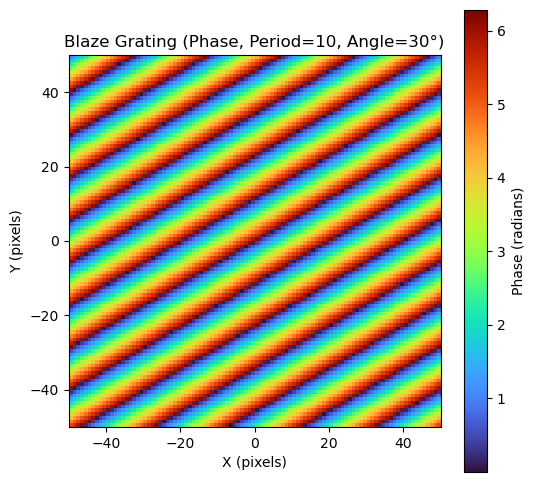

In [15]:
def generate_blaze_grating_phase(size, period, angle):
    """
    Generates a blaze grating in phase using PyTorch.

    Parameters:
        size (tuple): The size of the array (height, width).
        period (float): The period of the grating in pixels.
        angle (float): The orientation angle of the grating in degrees.

    Returns:
        torch.Tensor: A 2D tensor representing the blaze grating in phase.
    """
    # Define the grid
    height, width = size
    y = torch.linspace(-height // 2, height // 2, height)
    x = torch.linspace(-width // 2, width // 2, width)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    # Convert angle to radians
    theta = torch.deg2rad(torch.tensor(angle))

    # Compute the grating phase
    phase = 2 * torch.pi * (X * torch.cos(theta) + Y * torch.sin(theta)) / period

    # Wrap the phase to the range [0, 2π]
    blaze_phase = phase % (2 * torch.pi)

    return blaze_phase

# Example usage
size = (100, 100)  # Array size (height, width)
period = 10        # Period in pixels
angle = 30         # Orientation angle in degrees

blaze_grating_phase = generate_blaze_grating_phase(size, period, angle)

# Plot the result
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(blaze_grating_phase.numpy(), cmap='turbo', extent=(-size[1]//2, size[1]//2, -size[0]//2, size[0]//2))
plt.colorbar(label='Phase (radians)')
plt.title(f'Blaze Grating (Phase, Period={period}, Angle={angle}°)')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()


In [16]:
from NN_utils import Lin_ONN

Time for Torch FFT: 0.000000 seconds


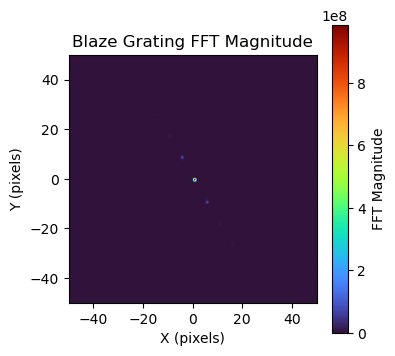

In [17]:
# Start timing for the FFT only
start_time = time.time()

# Compute the 2D FFT
blaze_fft = torch.fft.fft2(blaze_grating_phase)

end_time = time.time()

# Compute the magnitude (norm) of the FFT
blaze_fft_magnitude = torch.abs(blaze_fft)**2

# Timing
torch_FFT_time = end_time - start_time
print(f'Time for Torch FFT: {torch_FFT_time:.6f} seconds')

# Plot the magnitude of the FFT
plt.figure(figsize=(4, 4))
plt.imshow(
    torch.fft.fftshift(blaze_fft_magnitude).numpy(),  # fftshift centers the low frequencies
    cmap='turbo',
    extent=(-size[1]//2, size[1]//2, -size[0]//2, size[0]//2),
)
plt.colorbar(label='FFT Magnitude')
plt.title('Blaze Grating FFT Magnitude')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()


In [ ]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))


ONN = Lin_ONN(SLM_size=100)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move input data to the device
X_train_MNIST = X_train_MNIST.to(device)

# Move model to the device
ONN.to(device)

# Measure forward pass time
torch.cuda.synchronize()
start_time = time.time()

# Forward pass
Y = ONN.forward(X_train_MNIST)

torch.cuda.synchronize()
end_time = time.time()

print(f'Forward pass time: {end_time - start_time} seconds')

2

2.0